In [1]:
!pip install faiss-cpu numpy pandas matplotlib seaborn rank_bm25


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 25.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/npl')
!pwd


/content/drive/My Drive/npl


In [4]:
import json
import faiss
import numpy as np
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer

with open("processed_products.json", "r", encoding="utf-8") as f:
    products = json.load(f)

faiss_index = faiss.read_index("faiss_index.bin")
model = SentenceTransformer("all-MiniLM-L6-v2")

tokenized_corpus = [p["full_text"].split() for p in products]
bm25 = BM25Okapi(tokenized_corpus)

ground_truth = []
top_k = 5

for idx, query_product in enumerate(products[:200]):
    query_text = query_product["description"]

    bm25_scores = bm25.get_scores(query_text.split())
    bm25_top_k = np.argsort(bm25_scores)[::-1][:top_k]

    query_vector = model.encode([query_text], convert_to_numpy=True)
    _, faiss_top_k = faiss_index.search(query_vector, top_k)

    ground_truth.append({
        "query": query_text,
        "bm25_results": [products[i]["item_id"] for i in bm25_top_k],
        "faiss_results": [products[i]["item_id"] for i in faiss_top_k[0]],
        "true_item": query_product["item_id"]
    })

with open("ground_truth.json", "w", encoding="utf-8") as f:
    json.dump(ground_truth, f, indent=4, ensure_ascii=False)

print(f"Generated ground-truth for {len(ground_truth)} queries!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generated ground-truth for 200 queries!


In [5]:
from rank_bm25 import BM25Okapi
import json

with open("processed_products.json", "r") as f:
    products = json.load(f)
with open("ground_truth.json", "r") as f:
    ground_truth_data = json.load(f)

product_descriptions = [item.get("full_text", item["description"]) for item in products]
product_name = [item["item_name"] for item in products]
product_ids = [item["item_id"] for item in products]

def bm25_search(query, top_k=5):
    tokenized_query = nltk.word_tokenize(query.lower())
    scores = bm25.get_scores(tokenized_query)
    ranked_indices = np.argsort(scores)[::-1][:top_k]

    results = []
    for idx in ranked_indices:
        results.append({
            "item_id": product_ids[idx],
            "item_name": product_name[idx],
            "bm25_score": float(scores[idx])
        })
    return results


In [6]:
import nltk
nltk.download("punkt_tab")

tokenized_corpus = [nltk.word_tokenize(desc.lower()) for desc in product_descriptions]
bm25 = BM25Okapi(tokenized_corpus)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [7]:
index_faiss = faiss.read_index("faiss_index.bin")
index_faiss_finetuned = faiss.read_index("faiss_index_finetuned.bin")

# Load embedding models
model = SentenceTransformer("all-MiniLM-L6-v2")
fine_tuned_model = SentenceTransformer("fine_tuned_model")

In [8]:
import numpy as np

def faiss_search(query, top_k=5, fine_tuned=False):
    model_to_use = fine_tuned_model if fine_tuned else model
    query_vector = model_to_use.encode([query]).astype(np.float32)

    index_to_use = index_faiss_finetuned if fine_tuned else index_faiss
    distances, indices = index_to_use.search(query_vector, top_k)

    results = []
    for idx, dist in zip(indices[0], distances[0]):
        if idx < len(products):
            results.append({**products[idx], "distance": dist})
    return results


In [9]:
def hybrid_search(query, top_k=5, fine_tuned=False):
    bm25_results = bm25_search(query, top_k * 2)
    faiss_results = faiss_search(query, top_k * 2, fine_tuned)

    combined_scores = {}
    for rank, item in enumerate(bm25_results):
        combined_scores[item["item_id"]] = 1 / (rank + 1)

    for item in faiss_results:
        if item["item_id"] in combined_scores:
            combined_scores[item["item_id"]] += 1 / (item["distance"] + 1e-5)  # FAISS distance-based score
        else:
            combined_scores[item["item_id"]] = 1 / (item["distance"] + 1e-5)

    sorted_results = sorted(products, key=lambda p: combined_scores.get(p["item_id"], 0), reverse=True)[:top_k]
    return sorted_results


In [10]:
def recall_at_k(results, ground_truth, k):
    return sum(1 for r in results[:k] if r["item_id"] in ground_truth) / min(k, len(ground_truth))

def mrr(results, ground_truth):
    for i, r in enumerate(results):
        if r["item_id"] in ground_truth:
            return 1 / (i + 1)
    return 0

def dcg_at_k(results, ground_truth, k):
    return sum(1 / np.log2(i + 2) if r["item_id"] in ground_truth else 0 for i, r in enumerate(results[:k]))

def ndcg_at_k(results, ground_truth, k):
    ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(k, len(ground_truth))))
    return dcg_at_k(results, ground_truth, k) / ideal_dcg if ideal_dcg > 0 else 0


In [11]:
!pip install transformers sentencepiece torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [12]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

tkmodel_name = "Vamsi/T5_Paraphrase_Paws"
tokenizer = T5Tokenizer.from_pretrained(tkmodel_name)
tkmodel = T5ForConditionalGeneration.from_pretrained(tkmodel_name)

def paraphrase_query(query, num_return_sequences=3):
    input_text = f"paraphrase: {query} </s>"
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=256)
    output = tkmodel.generate(
        input_ids,
        max_length=256,
        num_return_sequences=1,
        do_sample=True,
        top_k=50,
        top_p=0.95
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [14]:
import time
import pandas as pd
import matplotlib.pyplot as plt

methods = ["FAISS", "FAISS_Finetuned", "Hybrid_FAISS", "Hybrid_FAISS_Finetuned"]
metrics = {m: {"recall@5": [], "mrr": [], "ndcg@5": [], "time": []} for m in methods}

for query_item in ground_truth_data:
    query = paraphrase_query(query_item["query"])
    true_item = query_item["true_item"]

    for method in methods:
        start = time.time()
        if method == "FAISS":
            results = faiss_search(query, top_k=5, fine_tuned=False)
        elif method == "FAISS_Finetuned":
            results = faiss_search(query, top_k=5, fine_tuned=True)
        elif method == "Hybrid_FAISS":
            results = hybrid_search(query, top_k=5, fine_tuned=False)
        else:
            results = hybrid_search(query, top_k=5, fine_tuned=True)

        duration = time.time() - start
        metrics[method]["recall@5"].append(recall_at_k(results, {true_item}, 5))
        metrics[method]["mrr"].append(mrr(results, {true_item}))
        metrics[method]["ndcg@5"].append(ndcg_at_k(results, {true_item}, 5))
        metrics[method]["time"].append(duration)

df = pd.DataFrame({m: {k: sum(v) / len(v) for k, v in metrics[m].items()} for m in methods}).T
print(df)


/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


                        recall@5       mrr    ndcg@5      time
FAISS                      0.180  0.148917  0.156668  0.013049
FAISS_Finetuned            0.310  0.229583  0.249289  0.012159
Hybrid_FAISS               0.255  0.239167  0.243116  0.161918
Hybrid_FAISS_Finetuned     0.315  0.257250  0.271786  0.156791


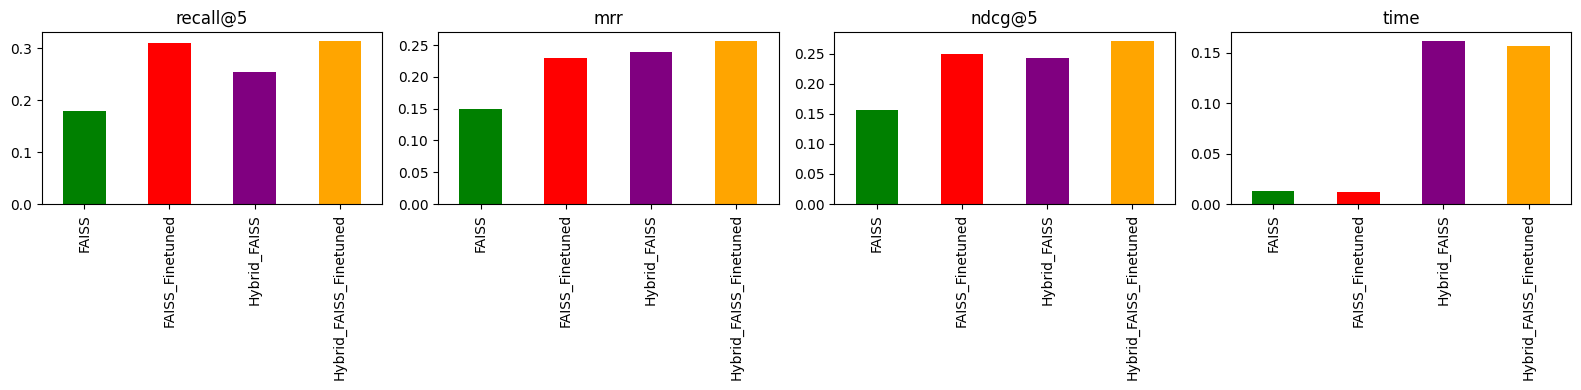

In [15]:
# Plot Results
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, metric in zip(axes, ["recall@5", "mrr", "ndcg@5", "time"]):
    df[metric].plot(kind="bar", ax=ax, title=metric, color=["green", "red", "purple", "orange"])
plt.tight_layout()
plt.show()
